# load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, count, lit

In [4]:
# create a spark session
spark = SparkSession.builder.appName("HospitalReadmissionEDA").getOrCreate()

# load data

In [5]:
# Load the Data into a Spark DataFrame
data_path = '../data/diabetic_data.csv'
df_spark = spark.read.csv(data_path, header=True)

# Initial Inspection with PySpark
print(f"Number of rows: {df_spark.count()}")
print(f"Number of columns: {len(df_spark.columns)}")

# Show the first 5 rows
df_spark.show(5)

# Print the schema that Spark inferred
df_spark.printSchema()

Number of rows: 101766
Number of columns: 50
+------------+-----------+---------------+------+-------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_

# clean data

In [6]:
# create a list of all column names
all_columns = df_spark.columns

In [7]:
# loop through each column to replace? with null
df_cleaned = df_spark 
for column in all_columns:
    df_cleaned = df_cleaned.withColumn(column, 
                                      when(col(column) == "?", None).otherwise(col(column))
                                      )
print("Replaced '?' with null values.")

Replaced '?' with null values.


In [8]:
df_cleaned.show(5)

+------------+-----------+---------------+------+-------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnos

In [9]:
df_cleaned.select('race').show(10)

+---------------+
|           race|
+---------------+
|      Caucasian|
|      Caucasian|
|AfricanAmerican|
|      Caucasian|
|      Caucasian|
|      Caucasian|
|      Caucasian|
|      Caucasian|
|      Caucasian|
|      Caucasian|
+---------------+
only showing top 10 rows


In [10]:
# get total number of rows
total_rows = df_cleaned.count()
total_rows

101766

In [11]:
# calculate missing values count and percentage for each column
missing = df_cleaned.select([(count(when(col(c).isNull(), c))/total_rows*100).alias(c) for c in all_columns])
missing.toPandas()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,0.0,0.0,2.233555,0.0,0.0,96.858479,0.0,0.0,0.0,0.0,39.557416,49.082208,0.0,0.0,0.0,0.0,0.0,0.0,0.020636,0.351787,1.398306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# List of columns to drop
cols_to_drop = [
    'weight',              # 96.9% missing
    'payer_code',          # 39.6% missing
    'medical_specialty',   # 49.1% missing
    'encounter_id',        # Identifier
    'patient_nbr',         # Identifier
]

# Drop the columns
df_reduced = df_cleaned.drop(*cols_to_drop)

# Verify the change
print(f"Original number of columns: {len(df_cleaned.columns)}")
print(f"Number of columns after dropping: {len(df_reduced.columns)}")

Original number of columns: 50
Number of columns after dropping: 45


# check target variable

In [13]:
df_reduced.select('readmitted').distinct().show()

+----------+
|readmitted|
+----------+
|       >30|
|        NO|
|       <30|
+----------+



In [14]:
df_resuced_pandas = df_reduced.groupby('readmitted').count().toPandas()

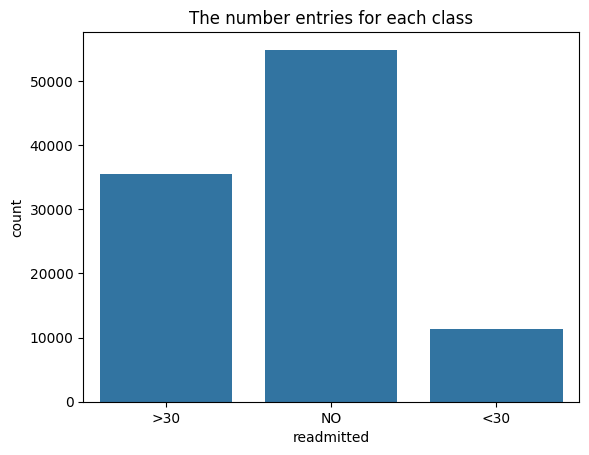

In [15]:
sns.barplot(data = df_resuced_pandas, x = 'readmitted', y = 'count')
plt.title("The number entries for each class")
plt.show()

<font color=red>The dataset is imbalanced if we investigate 3 classes.

In [16]:
# We map three strings to three numbers.
df_reduced_with_target = df_reduced.withColumn('label',
    when(col('readmitted') == 'NO', 0.0)
    .when(col('readmitted') == '<30', 1.0)
    .when(col('readmitted') == '>30', 1.0)
    .otherwise(None) # Should not happen, but good practice
).na.drop(subset=["label"]).drop('readmitted')

df_reduced_with_target = df_reduced_with_target.withColumn("label", col("label").cast("double"))

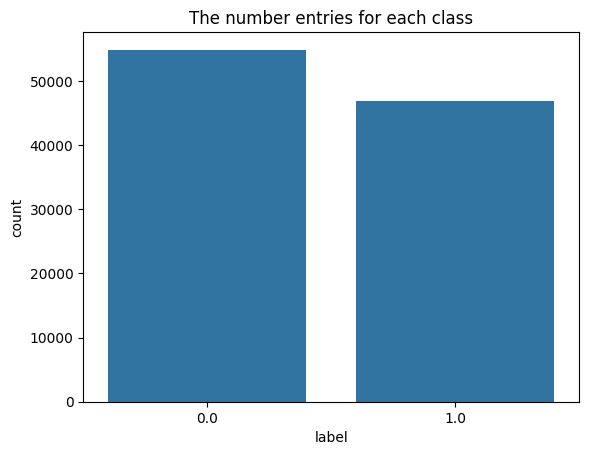

In [17]:
df_reduced_with_target_pandas = df_reduced_with_target.groupby('label').count().toPandas()
sns.barplot(data = df_reduced_with_target_pandas, x = 'label', y = 'count')
plt.title("The number entries for each class")
plt.show()

<font color=red>Now, investigate 2 classes, the dataset balance looks much better.

# categorize diag_1

In [18]:
df_reduced_with_target.groupby('diag_1').count().show()

+------+-----+
|diag_1|count|
+------+-----+
|   296|  896|
|   451|   40|
|   853|   18|
|   800|    6|
|250.01|   61|
|   447|   63|
|   591|   19|
|     7|    2|
|   574|  965|
|   475|   14|
|   718|   17|
|   307|   25|
|   577| 1057|
|   581|   19|
|   205|   27|
|   747|    7|
|   334|    2|
|   462|   11|
|   711|   66|
|   647|    5|
+------+-----+
only showing top 20 rows


In [19]:
# Create the new simplified diagnosis category column
df_engineered_with_target = df_reduced_with_target.withColumn('diag_1_category',
    when(col('diag_1').like('250%'), 'Diabetes')
    .when((col('diag_1') >= '390') & (col('diag_1') <= '459') | (col('diag_1') == '785'), 'Circulatory')
    .when((col('diag_1') >= '460') & (col('diag_1') <= '519') | (col('diag_1') == '786'), 'Respiratory')
    .when((col('diag_1') >= '520') & (col('diag_1') <= '579') | (col('diag_1') == '787'), 'Digestive')
    .when((col('diag_1') >= '800') & (col('diag_1') <= '999'), 'Injury')
    .when((col('diag_1') >= '710') & (col('diag_1') <= '739'), 'Musculoskeletal')
    .when((col('diag_1') >= '580') & (col('diag_1') <= '629') | (col('diag_1') == '788'), 'Genitourinary')
    .when((col('diag_1') >= '140') & (col('diag_1') <= '239'), 'Neoplasms')
    .otherwise('Other')
)

# Show the result of our new feature
print("Distribution of the new 'diag_1_category' feature:")
df_engineered_with_target.groupBy('diag_1_category').count().orderBy('count', ascending=False).show()

Distribution of the new 'diag_1_category' feature:
+---------------+-----+
|diag_1_category|count|
+---------------+-----+
|    Circulatory|30490|
|          Other|17955|
|    Respiratory|14465|
|      Digestive| 9543|
|       Diabetes| 8757|
|         Injury| 7046|
|  Genitourinary| 5118|
|Musculoskeletal| 4957|
|      Neoplasms| 3435|
+---------------+-----+



# handle missing values

In [20]:
# Find the most frequent value (the mode) for the 'race' column
mode_race = df_engineered_with_target.groupBy('race').count().orderBy('count', ascending=False).first()[0]
print(f"The most frequent race is: '{mode_race}'. We will use this to fill missing values.")

# Fill the nulls with the mode
df_imputed_with_target = df_engineered_with_target.fillna({'race': mode_race})

# We'll also fill nulls in our new diag_1_category with 'Other'. For simplicity, we'll now drop the original diag columns
df_imputed_with_target = df_imputed_with_target.fillna({'diag_1_category': 'Other'}).drop('diag_1', 'diag_2', 'diag_3')

df_imputed_with_target.printSchema()

The most frequent race is: 'Caucasian'. We will use this to fill missing values.
root
 |-- race: string (nullable = false)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: string (nullable = true)
 |-- num_lab_procedures: string (nullable = true)
 |-- num_procedures: string (nullable = true)
 |-- num_medications: string (nullable = true)
 |-- number_outpatient: string (nullable = true)
 |-- number_emergency: string (nullable = true)
 |-- number_inpatient: string (nullable = true)
 |-- number_diagnoses: string (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- 

# establish pipline

In [21]:
# Separate columns into categorical and numerical lists
# The target variable 'readmitted_binary' is separate
categorical_cols = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'metformin',
    'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone',
    'change', 'diabetesMed', 'diag_1_category'
]

numerical_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

target_col = 'label'

# Create a new DataFrame with the correct types since the numerical columns are string
df_final = df_imputed_with_target
for c in numerical_cols:
    df_final = df_final.withColumn(c, col(c).cast('integer'))

print("\nFinal number of columns before modeling:", len(df_final.columns))
df_final.printSchema()


Final number of columns before modeling: 43
root
 |-- race: string (nullable = false)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- glimepiride: string (nullabl

In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# --- STAGE 1 & 2: String Indexing and One-Hot Encoding for Categorical Columns ---
# We create a list to hold all the stages of our pipeline
stages = []

# Loop through each categorical column
for col_name in categorical_cols:
    # 1. StringIndexer, Rule: StringIndexer orders categories by descending frequency in the dataset.
    # That means:The most frequent label gets index 0. The next most frequent gets 1, and so on.

    string_indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="keep")
    # 2. OneHotEncoder
    one_hot_encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[col_name + "_vec"])
    # Add these two stages to our pipeline
    stages += [string_indexer, one_hot_encoder]

# --- STAGE 3: Vector Assembly ---
# Create a list of all feature columns to be assembled
# This includes the one-hot encoded vectors and the original numerical columns
assembler_inputs = [c + "_vec" for c in categorical_cols] + numerical_cols

# Create the VectorAssembler stage
vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Add the assembler to our stages
stages += [vector_assembler]

# --- Create and Run the Pipeline ---
# Define the pipeline with all the stages
preprocessing_pipeline = Pipeline(stages=stages)

# Fit the pipeline to our data to "learn" the transformations
pipeline_model = preprocessing_pipeline.fit(df_final)

# Transform the data to apply the transformations
df_model_ready = pipeline_model.transform(df_final)

print("Pipeline created and data transformed successfully.")

# --- Inspect the Result ---
# Let's look at the final DataFrame. You'll see the new columns,
# especially the 'features' vector and our target column.
df_model_ready.select(target_col, 'features').show(5, truncate=False)

Pipeline created and data transformed successfully.
+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                                                           |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
(trainingData, testData) = df_model_ready.randomSplit([0.8, 0.2], seed=42)

# Cache the data to speed up repeated access
trainingData.cache()
testData.cache()

print(f"Number of training samples: {trainingData.count()}")
print(f"Number of testing samples: {testData.count()}")

Number of training samples: 81565
Number of testing samples: 20201


# Test_1 logistic regression

In [24]:
from pyspark.ml.classification import LogisticRegression

# Instantiate the Logistic Regression model
# It will use our 'features' and 'label' columns
lr_1 = LogisticRegression(featuresCol='features', labelCol='label')

# Train the model by fitting it to the training data
print("Training the Logistic Regression model...")
lr_model_1 = lr_1.fit(trainingData)
print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


In [25]:
# Make predictions on the test data
predictions = lr_model_1.transform(testData)

# Let's look at the predictions
# The 'prediction' column is what the model guessed.
print("Sample predictions:")
predictions.select('label', 'prediction', 'probability').show(10, truncate=False)

Sample predictions:
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|1.0  |0.0       |[0.9135530478917262,0.0864469521082738] |
|0.0  |0.0       |[0.6215651277872323,0.3784348722127677] |
|0.0  |0.0       |[0.7176504937220364,0.2823495062779636] |
|1.0  |0.0       |[0.6701461833734644,0.32985381662653557]|
|1.0  |1.0       |[0.3941754870746486,0.6058245129253514] |
|0.0  |0.0       |[0.735584179743722,0.26441582025627797] |
|0.0  |0.0       |[0.6307591230999106,0.36924087690008944]|
|1.0  |0.0       |[0.6768202941542021,0.3231797058457979] |
|1.0  |0.0       |[0.7169111179262376,0.28308888207376237]|
|1.0  |0.0       |[0.6487159264231362,0.35128407357686375]|
+-----+----------+----------------------------------------+
only showing top 10 rows


In [26]:
predictions.columns

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'label',
 'diag_1_category',
 'race_index',
 'race_vec',
 'gender_index',
 'gender_vec',
 'age_index',
 'age_vec',
 'admission_type_id_index',
 'admission_type_id_vec',
 'discharge_disposition_id_index',
 'discharge_disposition_id_vec',
 'admission_source_id_in

In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)
print(f"Area Under ROC (AUC) = {auc:.4f}")

# Recall
evaluator_recall_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                              metricName="recallByLabel", metricLabel=1.0)
recall = evaluator_recall_positive.evaluate(predictions)
print(f"Recall (for Readmitted Class 1.0) = {recall:.2%}")

# Precision
evaluator_precision_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                                  metricName="precisionByLabel", metricLabel=1.0)
precision = evaluator_precision_positive.evaluate(predictions)
print(f"Precision (for Readmitted Class 1.0) = {precision:.2%}")

# F1 score
evaluator_f1_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                          metricName="f1", metricLabel=1.0)
f1_score = evaluator_f1_positive.evaluate(predictions)
print(f"F1 Score (for Readmitted Class 1.0) = {f1_score:.4f}")

# --- Detailed View: Confusion Matrix ---
# Shows how many times the model predicted each class vs. the actual class.
print("\nConfusion Matrix:")
# Convert to Pandas for a nice crosstab view
preds_and_labels = predictions.select(['prediction', 'label']).toPandas()
confusion_matrix = pd.crosstab(preds_and_labels['label'], preds_and_labels['prediction'])
print(confusion_matrix)

Area Under ROC (AUC) = 0.6891
Recall (for Readmitted Class 1.0) = 48.83%
Precision (for Readmitted Class 1.0) = 64.05%
F1 Score (for Readmitted Class 1.0) = 0.6300

Confusion Matrix:
prediction   0.0   1.0
label                 
0.0         8334  2553
1.0         4766  4548


# Test_2 logistic regression with weighted column

In [28]:
# Calculate the balance ratio
num_positives = df_model_ready.filter(col('label') == 1.0).count()
num_negatives = df_model_ready.filter(col('label') == 0.0).count()

# The weight for the majority class (0.0) should be smaller
weight_for_negatives = num_positives / (num_positives + num_negatives)

# The weight for the minority class (1.0) should be larger
weight_for_positives = num_negatives / (num_positives + num_negatives)

print(f"Weight for class 0: {weight_for_negatives:.2f}")
print(f"Weight for class 1: {weight_for_positives:.2f}")

# Add a weight column to the DataFrame
df_weighted = df_model_ready.withColumn('classWeight',
    when(col('label') == 0.0, weight_for_negatives)
    .otherwise(weight_for_positives)
)

# Split this NEW df_weighted DataFrame
(trainingData, testData) = df_weighted.randomSplit([0.8, 0.2], seed=42)

# Now, when you instantiate your model, tell it to use this column
# If you are using LogisticRegression:
lr_2 = LogisticRegression(featuresCol='features', labelCol='label', weightCol='classWeight')
lr_model_2 = lr_2.fit(trainingData)
predictions = lr_model_2.transform(testData)

Weight for class 0: 0.46
Weight for class 1: 0.54


In [29]:
# AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)
print(f"Area Under ROC (AUC) = {auc:.4f}")

# Recall
evaluator_recall_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                              metricName="recallByLabel", metricLabel=1.0)
recall = evaluator_recall_positive.evaluate(predictions)
print(f"Recall (for Readmitted Class 1.0) = {recall:.2%}")

# Precision
evaluator_precision_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                                  metricName="precisionByLabel", metricLabel=1.0)
precision = evaluator_precision_positive.evaluate(predictions)
print(f"Precision (for Readmitted Class 1.0) = {precision:.2%}")

# F1 score
evaluator_f1_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                          metricName="f1", metricLabel=1.0)
f1_score = evaluator_f1_positive.evaluate(predictions)
print(f"F1 Score (for Readmitted Class 1.0) = {f1_score:.4f}")

# --- Detailed View: Confusion Matrix ---
# Shows how many times the model predicted each class vs. the actual class.
print("\nConfusion Matrix:")
# Convert to Pandas for a nice crosstab view
preds_and_labels = predictions.select(['prediction', 'label']).toPandas()
confusion_matrix = pd.crosstab(preds_and_labels['label'], preds_and_labels['prediction'])
print(confusion_matrix)


Area Under ROC (AUC) = 0.6892
Recall (for Readmitted Class 1.0) = 60.15%
Precision (for Readmitted Class 1.0) = 60.55%
F1 Score (for Readmitted Class 1.0) = 0.6355

Confusion Matrix:
prediction   0.0   1.0
label                 
0.0         7237  3650
1.0         3712  5602


# Test_3 random forest with weighted column

In [30]:
from pyspark.ml.classification import RandomForestClassifier

# 1. Instantiate the RandomForest model, making sure to use the weightCol!
rf_1 = RandomForestClassifier(featuresCol='features', 
                            labelCol='label', 
                            weightCol='classWeight',  # Crucial to keep this
                            seed=42)                 # For reproducibility

# 2. Train the model on your weighted training data
print("Training the weighted RandomForest model...")
rf_model_1 = rf_1.fit(trainingData)
print("Model training complete.")

# 3. Make predictions on the UNTOUCHED test data
predictions_rf = rf_model_1.transform(testData)

# 4. Evaluate the new model using your corrected evaluation code
print("\n--- Evaluation of RandomForest Model ---")

# --- AUC ---
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions_rf)
print(f"Area Under ROC (AUC) = {auc:.4f}")

# --- Recall for Positive Class ---
evaluator_recall_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel", metricLabel=1.0)
recall = evaluator_recall_positive.evaluate(predictions_rf)
print(f"Recall (for Readmitted Class 1.0) = {recall:.2%}")

# --- Precision for Positive Class ---
evaluator_precision_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel", metricLabel=1.0)
precision = evaluator_precision_positive.evaluate(predictions_rf)
print(f"Precision (for Readmitted Class 1.0) = {precision:.2%}")

# --- F1 Score for Positive Class ---
evaluator_f1_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1", metricLabel=1.0)
f1_score = evaluator_f1_positive.evaluate(predictions_rf)
print(f"F1 Score (for Readmitted Class 1.0) = {f1_score:.4f}")

# --- Confusion Matrix ---
print("\nConfusion Matrix (RandomForest):")
preds_and_labels_rf = predictions_rf.select(['prediction', 'label']).toPandas()
confusion_matrix_rf = pd.crosstab(preds_and_labels_rf['label'], preds_and_labels_rf['prediction'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix_rf)

Training the weighted RandomForest model...
Model training complete.

--- Evaluation of RandomForest Model ---
Area Under ROC (AUC) = 0.6690
Recall (for Readmitted Class 1.0) = 57.76%
Precision (for Readmitted Class 1.0) = 59.72%
F1 Score (for Readmitted Class 1.0) = 0.6251

Confusion Matrix (RandomForest):
Predicted   0.0   1.0
Actual               
0.0        7258  3629
1.0        3934  5380


# Test_4 tune random forest with weighted column

In [31]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf_2 = RandomForestClassifier(featuresCol='features', 
                            labelCol='label', 
                            weightCol='classWeight',  # Keep using the weights!
                            seed=42)

# --- Define a grid of hyperparameters to search ---
# We will test combinations of these settings.
paramGrid = (ParamGridBuilder()
             .addGrid(rf_2.maxDepth, [5, 10, 15])         # Test shallow and medium-depth trees
             .addGrid(rf_2.numTrees, [50, 100])           # Test a reasonable number of trees
             .addGrid(rf_2.minInstancesPerNode, [10, 20]) # Prevent splits on tiny nodes
             .build())

# --- Set up the evaluator ---
# We want to optimize for the best overall model, so AUC is the best metric.
# It will find the model that is fundamentally best at separating the classes.
evaluator = BinaryClassificationEvaluator(labelCol="label", 
                                          rawPredictionCol="rawPrediction", 
                                          metricName="areaUnderROC")

# --- Set up the CrossValidator ---
cv = CrossValidator(estimator=rf_2,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,  # Use 3 folds for speed. Can increase to 5 for more robustness.
                    parallelism=4) # Speeds up training if your machine has the cores

# --- Run the tuning process ---
# This is the most computationally expensive step. It will take time!
print("Starting hyperparameter tuning for RandomForest...")
cv_model = cv.fit(trainingData)
print("Tuning complete.")

# --- Get the best model and make predictions ---
best_rf_model = cv_model.bestModel
predictions_tuned = best_rf_model.transform(testData)

# --- Finally, evaluate the new, TUNED model ---
print("\n--- Evaluation of TUNED RandomForest Model ---")

# --- AUC ---
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions_tuned)
print(f"Area Under ROC (AUC) = {auc:.4f}")

# --- Recall for Positive Class ---
evaluator_recall_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel", metricLabel=1.0)
recall = evaluator_recall_positive.evaluate(predictions_tuned)
print(f"Recall (for Readmitted Class 1.0) = {recall:.2%}")

# --- Precision for Positive Class ---
evaluator_precision_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel", metricLabel=1.0)
precision = evaluator_precision_positive.evaluate(predictions_tuned)
print(f"Precision (for Readmitted Class 1.0) = {precision:.2%}")

# --- F1 Score for Positive Class ---
evaluator_f1_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1", metricLabel=1.0)
f1_score = evaluator_f1_positive.evaluate(predictions_tuned)
print(f"F1 Score (for Readmitted Class 1.0) = {f1_score:.4f}")

# --- Confusion Matrix ---
print("\nConfusion Matrix (RandomForest):")
preds_and_labels_rf = predictions_tuned.select(['prediction', 'label']).toPandas()
confusion_matrix_rf = pd.crosstab(preds_and_labels_rf['label'], preds_and_labels_rf['prediction'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix_rf)

Starting hyperparameter tuning for RandomForest...
Tuning complete.

--- Evaluation of TUNED RandomForest Model ---
Area Under ROC (AUC) = 0.6964
Recall (for Readmitted Class 1.0) = 60.29%
Precision (for Readmitted Class 1.0) = 61.37%
F1 Score (for Readmitted Class 1.0) = 0.6416

Confusion Matrix (RandomForest):
Predicted   0.0   1.0
Actual               
0.0        7352  3535
1.0        3699  5615


# Test_5 tune gradient boost with weighted column

In [32]:
from pyspark.ml.classification import GBTClassifier

# 1. Instantiate the GBTClassifier
# Make sure to use the 'weightCol' to handle class imbalance.
gbt = GBTClassifier(
    featuresCol='features',
    labelCol='label',
    weightCol='classWeight', # Use the same weight column!
    seed=42
)

# --- Define a grid of hyperparameters to search ---
# We will test combinations of these settings.
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10])               # Test shallow vs. medium trees. GBTs are often shallower than RF.
             .addGrid(gbt.maxIter, [20, 50])               # Test default vs. more iterations.
             .addGrid(gbt.stepSize, [0.1, 0.05])           # Test default learning rate vs. a smaller, more robust one.
             .addGrid(gbt.minInstancesPerNode, [10, 20])   # This is still a great parameter to control overfitting.
             .build())

# --- Set up the evaluator ---
# We want to optimize for the best overall model, so AUC is the best metric.
# It will find the model that is fundamentally best at separating the classes.
evaluator = BinaryClassificationEvaluator(labelCol="label", 
                                          rawPredictionCol="rawPrediction", 
                                          metricName="areaUnderROC")

# --- Set up the CrossValidator ---
cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,  # Use 3 folds for speed. Can increase to 5 for more robustness.
                    parallelism=4) # Speeds up training if your machine has the cores

# --- Run the tuning process ---
# This is the most computationally expensive step. It will take time!
print("Starting hyperparameter tuning for GradientBoost...")
cv_model = cv.fit(trainingData)
print("Tuning complete.")


# 2. Train the model
print("Training the GBTClassifier model...")
gbt_model = gbt.fit(trainingData)
print("Model training complete.")

# 3. Make predictions
predictions_gbt = gbt_model.transform(testData)

# 4. Evaluate the GBT model's performance
# You can use your exact same evaluation code block here.
print("\n--- Evaluation of GBTClassifier Model ---")

# --- AUC ---
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions_gbt)
print(f"Area Under ROC (AUC) = {auc:.4f}")

# --- Recall for Positive Class ---
evaluator_recall_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel", metricLabel=1.0)
recall = evaluator_recall_positive.evaluate(predictions_gbt)
print(f"Recall (for Readmitted Class 1.0) = {recall:.2%}")

# --- Precision for Positive Class ---
evaluator_precision_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel", metricLabel=1.0)
precision = evaluator_precision_positive.evaluate(predictions_gbt)
print(f"Precision (for Readmitted Class 1.0) = {precision:.2%}")

# --- F1 Score for Positive Class ---
evaluator_f1_positive = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1", metricLabel=1.0)
f1_score = evaluator_f1_positive.evaluate(predictions_gbt)
print(f"F1 Score (for Readmitted Class 1.0) = {f1_score:.4f}")

# --- Confusion Matrix ---
print("\nConfusion Matrix (GradientBoost):")
preds_and_labels_gbt = predictions_gbt.select(['prediction', 'label']).toPandas()
confusion_matrix_gbt = pd.crosstab(preds_and_labels_gbt['label'], preds_and_labels_gbt['prediction'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix_gbt)

Starting hyperparameter tuning for GradientBoost...
Tuning complete.
Training the GBTClassifier model...
Model training complete.

--- Evaluation of GBTClassifier Model ---
Area Under ROC (AUC) = 0.6876
Recall (for Readmitted Class 1.0) = 57.04%
Precision (for Readmitted Class 1.0) = 61.28%
F1 Score (for Readmitted Class 1.0) = 0.6345

Confusion Matrix (GradientBoost):
Predicted   0.0   1.0
Actual               
0.0        7530  3357
1.0        4001  5313


<font color=red>**There is no bug difference between random forest, tuned random forest and tuned gradient boost method. Maybe more feature engineering is helpful**